# Detecting EMA cross traps

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data["ema_fast"] = ta.ema(data["Close"], length=20)
data["ema_low"] = ta.ema(data["Close"], length=250)
data["ema_cross"] = ((data["ema_fast"] > data["ema_low"]) & (data["ema_fast"].shift(1) <= data["ema_low"].shift(1)) | (data["ema_fast"] < data["ema_low"]) & (data["ema_fast"].shift(1) >= data["ema_low"].shift(1)))

## Preparing data for detecting TRAP

In [5]:
def is_trap(r):
    trap = ''
    if r['ema_cross'] == True:
        if r['ema_fast'] > r['ema_low']:
            # Cross up
            if r['min_low_1dlater'] < r['Close'] - 3.5:
                trap = 1
            else:
                trap = 0
        else:
            # Cross down
            if r['max_high_1dlater'] > r['Close'] + 3.5:
                trap = 1
            else:
                trap = 0
    return trap

In [6]:
data['max_high_1dlater'] = data['High'].shift(-51).rolling(51).max()
data['min_low_1dlater'] = data['Low'].shift(-51).rolling(51).min()
data['trap'] = data.apply(lambda r: is_trap(r), axis=1)

In [7]:
# data.dropna(inplace=True)

In [8]:
data

,Open,High,Low,Close,Volume,ema_fast,ema_low,ema_cross,max_high_1dlater,min_low_1dlater,trap
Date,,,,,,,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812,NaN,NaN,False,NaN,NaN,
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323,NaN,NaN,False,NaN,NaN,
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207,NaN,NaN,False,NaN,NaN,
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196,NaN,NaN,False,NaN,NaN,
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765,NaN,NaN,False,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1343.0,1340.3,1341.3,7141,1343.885390,1337.889347,False,NaN,NaN,
2025-02-14 14:20:00,1340.9,1341.9,1340.5,1341.4,4593,1343.648686,1337.917321,False,NaN,NaN,
2025-02-14 14:25:00,1341.1,1342.5,1340.7,1342.5,4207,1343.539287,1337.953836,False,NaN,NaN,


## Prepare the Data for Training

In [11]:
df = data[data.trap !=''].copy().drop(columns=['max_high_1dlater', 'min_low_1dlater'])
df['trap'] = df['trap'].astype(int)

In [14]:
len(df[df.trap == 0]) / len(df['trap'])

0.39853747714808047

## Calculate Features

In [16]:
df["EMA_Diff"] = df["ema_fast"] - df["ema_low"]  # Distance between EMAs
# df["ATR"] = ta.atr(df["High"], df["Low"], df["Close"], length=14)  # Volatility
df["RSI"] = ta.rsi(df["Close"], length=14)  # Momentum indicator
df["BB_Width"] = ta.bbands(df["Close"], length=20)["BBU_20_2.0"] - ta.bbands(df["Close"], length=20)["BBL_20_2.0"]
# df["Volume_Change"] = df["Volume"] / df["Volume"].shift(1)  # Relative volume
# Extract Features Before EMA Cross
df['Price_Velocity'] = df['Close'].diff()  # Price speed
df['ATR'] = df['High'].rolling(14).max() - df['Low'].rolling(14).min()  # Volatility
df['Volume_Change'] = df['Volume'].pct_change()  # Volume spikes

## 2. Use Hidden Markov Model

In [17]:
from hmmlearn.hmm import GaussianHMM

In [22]:
ai_data = df.copy().dropna()
# Select only relevant columns
features = ai_data[['Price_Velocity', 'ATR', 'Volume_Change', 'RSI']]
# Train HMM
hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=100)
hmm_model.fit(features)

# Predict hidden states
ai_data['Market_State'] = hmm_model.predict(features)

# Map states (based on visualization)
# state_mapping = {0: 'Real Trend', 1: 'Trap', 2: 'Choppy Market'}
# ai_data['Market_State_Label'] = ai_data['Market_State'].map(state_mapping)

In [23]:
ai_data

,Open,High,Low,Close,Volume,ema_fast,ema_low,ema_cross,trap,EMA_Diff,RSI,BB_Width,Price_Velocity,ATR,Volume_Change,Market_State
Date,,,,,,,,,,,,,,,,
2018-11-05 13:05:00,890.5,892.4,890.5,891.6,2070,892.908499,892.929812,True,1,-0.021313,29.807029,131.825598,-2.8,110.1,-0.116894,2
2018-11-05 13:20:00,892.9,894.2,892.6,894.2,2905,892.947629,892.930863,True,0,0.016766,31.242617,139.946188,2.6,110.1,0.403382,2
2018-11-07 10:15:00,895.0,895.1,893.9,894.4,3478,896.098425,896.147319,True,1,-0.048895,31.358912,145.943434,0.2,110.1,0.197246,2
2018-11-07 10:25:00,896.0,897.4,896.0,896.9,4176,896.183518,896.153733,True,1,0.029784,32.886985,149.668512,2.5,110.1,0.200690,2
2018-11-07 13:15:00,893.4,893.9,892.5,892.9,3093,896.090237,896.211786,True,1,-0.121549,31.672083,152.923531,-4.0,110.1,-0.259339,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-04 13:40:00,1327.0,1328.6,1326.9,1327.9,2440,1326.119529,1326.024943,True,0,0.094586,53.243570,85.575686,8.9,60.4,0.137529,2
2025-02-10 09:50:00,1327.5,1328.0,1326.8,1327.9,2759,1334.554459,1335.013120,True,1,-0.458661,53.243570,80.263414,0.0,60.4,0.130738,2
2025-02-12 09:10:00,1340.2,1341.2,1340.1,1340.8,3136,1333.899323,1333.480473,True,1,0.418849,56.815834,68.621801,12.9,41.5,0.136644,2


In [26]:
# Evaluate Performance
print("Accuracy:", accuracy_score(ai_data['trap'], ai_data['Market_State']))

Accuracy: 0.017045454545454544


## 1. Use RandomForestClassifier model

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
# Define Features and Target Variable
features = ["EMA_Diff", "ATR", "RSI", "BB_Width", "Volume_Change"]
X = df[features]
y = df["trap"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
y

Date
2018-08-21 14:00:00    0
2018-08-30 10:15:00    1
2018-08-30 11:20:00    0
2018-09-04 10:35:00    0
2018-09-11 13:40:00    0
                      ..
2025-02-04 13:40:00    0
2025-02-10 09:50:00    1
2025-02-12 09:10:00    1
2025-02-13 09:10:00    1
2025-02-13 13:45:00    0
Name: trap, Length: 547, dtype: int64

In [55]:
# Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [56]:
# Predictions
y_pred = model.predict(X_test)

In [57]:
# Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6181818181818182
              precision    recall  f1-score   support

           0       0.59      0.42      0.49        48
           1       0.63      0.77      0.70        62

    accuracy                           0.62       110
   macro avg       0.61      0.60      0.59       110
weighted avg       0.61      0.62      0.60       110



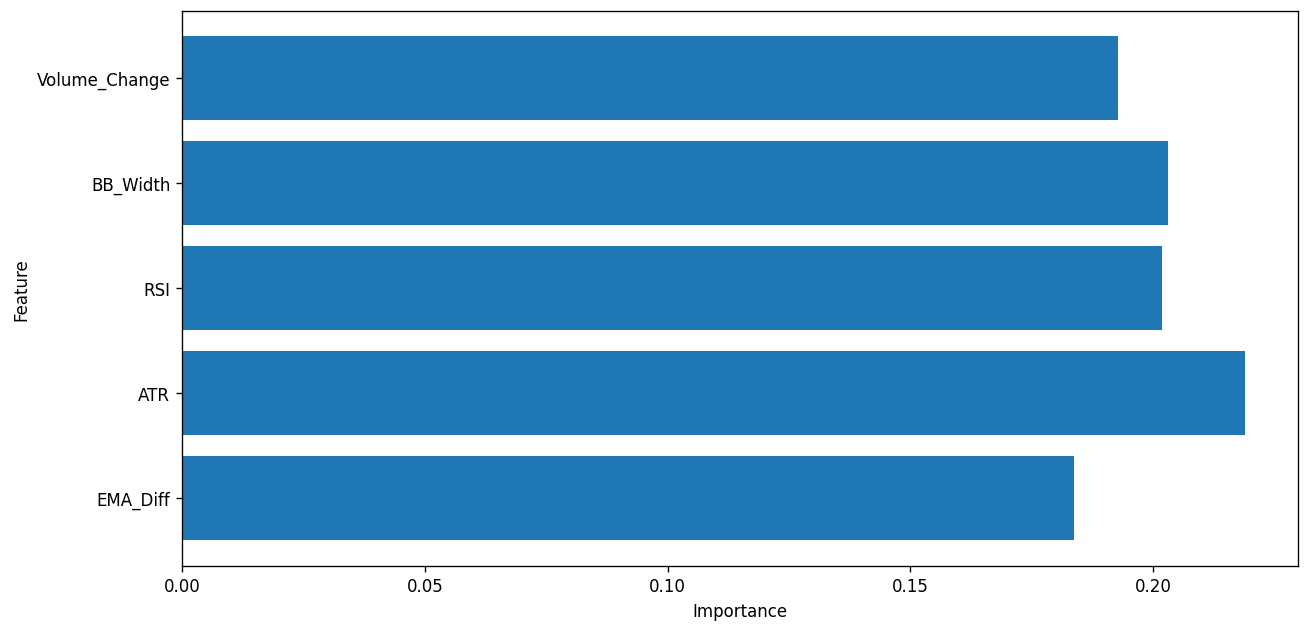

In [58]:
importances = model.feature_importances_
feature_names = X_train.columns

plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()